Caracteristicas: ['comprimento_sepala', 'largura_sepala', 'comprimento_petala', 'largura_petala']
Resultado: Especies
Loss test: 1.2505053281784058
Epoca 000: Perca: 1.201, Acuracia: 35.000%
Epoca 001: Perca: 1.152, Acuracia: 35.000%
Epoca 002: Perca: 1.119, Acuracia: 35.000%
Epoca 003: Perca: 1.097, Acuracia: 35.000%
Epoca 004: Perca: 1.082, Acuracia: 35.000%
Epoca 005: Perca: 1.069, Acuracia: 35.833%
Epoca 006: Perca: 1.058, Acuracia: 40.833%
Epoca 007: Perca: 1.049, Acuracia: 61.667%
Epoca 008: Perca: 1.042, Acuracia: 65.833%
Epoca 009: Perca: 1.038, Acuracia: 65.000%
Epoca 010: Perca: 1.035, Acuracia: 65.000%
Epoca 011: Perca: 1.031, Acuracia: 65.000%
Epoca 012: Perca: 1.027, Acuracia: 63.333%
Epoca 013: Perca: 1.024, Acuracia: 63.333%
Epoca 014: Perca: 1.020, Acuracia: 63.333%
Epoca 015: Perca: 1.017, Acuracia: 63.333%
Epoca 016: Perca: 1.013, Acuracia: 63.333%
Epoca 017: Perca: 1.010, Acuracia: 61.667%
Epoca 018: Perca: 1.006, Acuracia: 62.500%
Epoca 019: Perca: 1.003, Acuracia: 

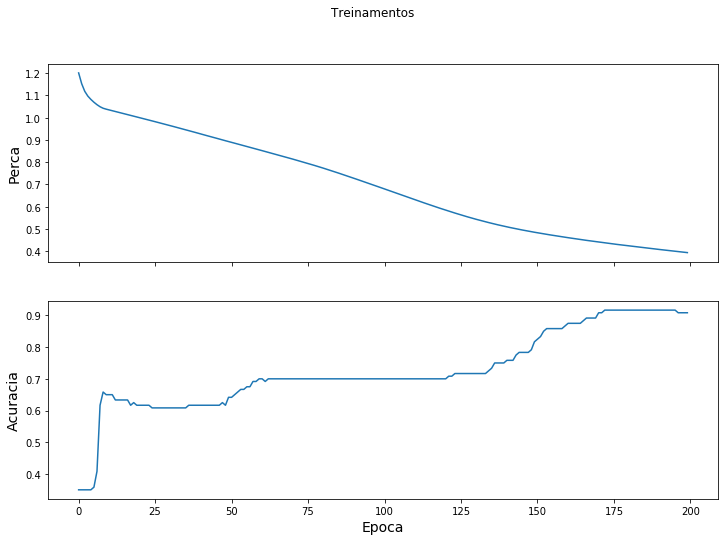

Teste 0 Resposta: Iris virginica (71.4% de certeza)
Teste 1 Resposta: Iris setosa (85.8% de certeza)
Teste 2 Resposta: Iris virginica (63.3% de certeza)
Teste 3 Resposta: Iris setosa (98.6% de certeza)
Teste 4 Resposta: Iris setosa (88.4% de certeza)
Teste 5 Resposta: Iris setosa (97.9% de certeza)
Teste 6 Resposta: Iris virginica (66.7% de certeza)
Teste 7 Resposta: Iris setosa (91.1% de certeza)
Teste 8 Resposta: Iris virginica (54.8% de certeza)
Teste 9 Resposta: Iris virginica (63.6% de certeza)
Teste 10 Resposta: Iris virginica (66.7% de certeza)
Teste 11 Resposta: Iris virginica (67.6% de certeza)
Teste 12 Resposta: Iris virginica (56.8% de certeza)
Teste 13 Resposta: Iris setosa (82.0% de certeza)
Teste 14 Resposta: Iris setosa (82.1% de certeza)
Acuracia Media do Teste:  75.74 %
[0.714, 0.857, 0.633, 0.986, 0.883, 0.979, 0.667, 0.91, 0.547, 0.636, 0.666, 0.675, 0.567, 0.82, 0.821]


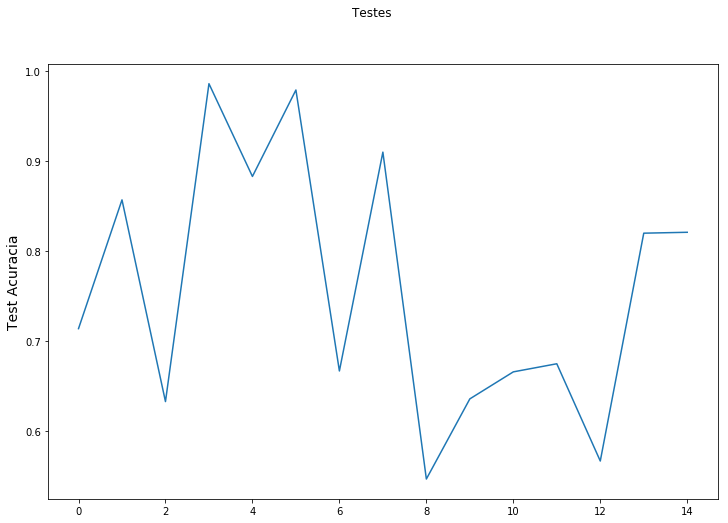

In [136]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
tf.enable_eager_execution()

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)


# Ordem das colunas no arquivo CSV
column_names = ['comprimento_sepala', 'largura_sepala', 'comprimento_petala', 'largura_petala', 'Especies']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Caracteristicas: {}".format(feature_names))
print("Resultado: {}".format(label_name))

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))



model = tf.keras.Sequential([
  tf.keras.layers.Dense(25, activation='relu', input_shape=(4,)),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(3)
])


def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

loss_value, grads = grad(model, features, labels)

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)


from tensorflow import contrib
tfe = contrib.eager

#Resultados para Plot
train_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

num_epochs = 200

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Loop Treino
  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)
    epoch_loss_avg(loss_value)
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoca {:03d}: Perca: {:.3f}, Acuracia: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Treinamentos')

axes[0].set_ylabel("Perca", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Acuracia", fontsize=14)
axes[1].set_xlabel("Epoca", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

'''
Teste por dataset
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


tf.stack([y,prediction],axis=1)'''

#teste Manual
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

x1 = []
x2 = []
x3 = []
x4 = []
for x in range(0, 15):
  x1.append(random.uniform(4.3, 7.9))
  x2.append(random.uniform(2.0, 4.4))
  x3.append(random.uniform(1.0, 6.9))
  x4.append(random.uniform(0.1, 2.5))

predict_dataset = tf.convert_to_tensor([
  [truncate(x1[0],1), truncate(x2[0],1), truncate(x3[0],1), truncate(x4[0],1),],
  [truncate(x1[1],1), truncate(x2[1],1), truncate(x3[1],1), truncate(x4[1],1),],
  [truncate(x1[2],1), truncate(x2[2],1), truncate(x3[2],1), truncate(x4[2],1),],
  [truncate(x1[3],1), truncate(x2[3],1), truncate(x3[3],1), truncate(x4[3],1),],
  [truncate(x1[4],1), truncate(x2[4],1), truncate(x3[4],1), truncate(x4[4],1),],
  [truncate(x1[5],1), truncate(x2[5],1), truncate(x3[5],1), truncate(x4[5],1),],
  [truncate(x1[6],1), truncate(x2[6],1), truncate(x3[6],1), truncate(x4[6],1),],
  [truncate(x1[7],1), truncate(x2[7],1), truncate(x3[7],1), truncate(x4[7],1),],
  [truncate(x1[8],1), truncate(x2[8],1), truncate(x3[8],1), truncate(x4[8],1),],
  [truncate(x1[9],1), truncate(x2[9],1), truncate(x3[9],1), truncate(x4[9],1),],
  [truncate(x1[10],1), truncate(x2[10],1), truncate(x3[10],1), truncate(x4[10],1),],
  [truncate(x1[11],1), truncate(x2[11],1), truncate(x3[11],1), truncate(x4[11],1),],
  [truncate(x1[12],1), truncate(x2[12],1), truncate(x3[12],1), truncate(x4[12],1),],
  [truncate(x1[13],1), truncate(x2[13],1), truncate(x3[13],1), truncate(x4[13],1),],
  [truncate(x1[14],1), truncate(x2[14],1), truncate(x3[14],1), truncate(x4[14],1)]
])
  
predictions = model(predict_dataset)
t=0
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Teste {} Resposta: {} ({:4.1f}% de certeza)".format(i, name, 100*p))
  test_accuracy_results.append(truncate(float(format(p)), 3))
  t+=test_accuracy_results[i]
print("Acuracia Media do Teste: ", truncate(t*100/len(test_accuracy_results), 2),"%")
fig, axes = plt.subplots( sharey=True, figsize=(12, 8))
fig.suptitle('Testes')
axes.set_ylabel("Test Acuracia", fontsize=14)
print(test_accuracy_results)
axes.plot(test_accuracy_results,)
plt.show()